# Importing

Libraries

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import cv2
import numpy as np
import easyocr
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import os


# TOOL

Class tool for OCR

Tesseract

In [ ]:
# import pytesseract

# # Nếu dùng Windows, set path nếu cần
# class Processing:
#     def __init__(self, num_threads=4, gpu = False):
#         # For task detect
#         pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
#         self.paddle_reader = PaddleOCR(lang='en', show_log=False,use_gpu = gpu)
#         # For run many task simultaneously (don't test this function, it is not complete) 
#         self.num_threads = num_threads
    
#     def rec(self, image):
#         # OCR tiếng Việt
#         text = pytesseract.image_to_string(image, lang='vie')
#         return text
    
#     def find_rects_texts(self, img_path, mode_draw= 0):
#         '''Function for find rects (bounding box) and text respectively'''
#         image = cv2.imread(img_path)
#         if image is None:
#             raise FileNotFoundError(f"Cannot read image at path: {img_path}")
#         img = image.copy()
#         a = 10
#         b = a / 1.5
#         h, w = image.shape[:2]
#         image_resized = cv2.resize(image, (int(w * a), int(h * b)))
#         result = self.paddle_reader.ocr(image_resized, cls=True, rec= False)[0][::-1]

#         rects, horizontal_list, texts = [], [], []

#         padding = 6
#         for line in result:
#             box = np.array(line, dtype=np.float32)
#             x, y, w, h = cv2.boundingRect(box)
#             x1, y1 = max(int(int(x / a) - padding), 0), max(int(int(y / b) - padding), 0)
#             x2, y2 = int(int((x + w) / a) + padding), int(int((y + h) / b) + padding)

#             rects.append([x1, y1, x2, y2])
#             img_cut = img[y1:y2, x1:x2]
#             text = self.rec(img_cut).strip()
#             texts.append(text)
#             # horizontal_list.append([x1, x2, y1, y2])

#         rects = np.array(rects, dtype=int)

#         if mode_draw:
#             for rect in rects:
#                 cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 1)
#             plt.figure(figsize=(12, 12))
#             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#             plt.axis('off')
#             plt.show()

#         return rects, texts

#     def check_line(self, box1, box2):
#         '''Check two bounding are all on a line'''
#         return abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10

#     def rects_texts_ncollum_processed(self, rects, texts):
#         rects_new, txts_new = [], []
#         current_rect, current_txt = [], []
#         max_col = 0

#         for i, text in enumerate(texts):
#             text = text.strip()
#             if not text: 
#                 continue
#             if text[0].isdigit() and text[-1].isdigit():
#                 text = text.replace(',', '.')

#             if not current_rect or self.check_line(current_rect[-1], rects[i]):
#                 current_rect.append(rects[i])
#                 current_txt.append(text)
#             else:
#                 combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
#                 cur_rect_sorted, cur_txt_sorted = zip(*combined)
#                 rects_new.append(np.array(cur_rect_sorted))
#                 txts_new.append(list(cur_txt_sorted))
#                 max_col = max(max_col, len(cur_txt_sorted))
#                 current_rect = [rects[i]]
#                 current_txt = [text]

#         if current_rect:
#             combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
#             cur_rect_sorted, cur_txt_sorted = zip(*combined)
#             rects_new.append(np.array(cur_rect_sorted))
#             txts_new.append(list(cur_txt_sorted))
#             max_col = max(max_col, len(cur_txt_sorted))

#         return rects_new, txts_new, max_col

#     def find_box_cols(self, rects_box, n_cols):
#         cols_data = [row[:, [0, 2]].flatten() for row in rects_box if len(row) == n_cols]
#         cols_data = np.array(cols_data)

#         col_xmin = cols_data[:, ::2].min(axis=0)
#         col_xmax = cols_data[:, 1::2].max(axis=0)

#         return np.stack((col_xmin, col_xmax), axis=1)

#     def find_text_each_row(self, box_cols, list_rects, list_texts):
#         result = []
#         for row_rects, row_texts in zip(list_rects, list_texts):
#             row_data = [''] * len(box_cols)
#             for rect, text in zip(row_rects, row_texts):
#                 x_center = (rect[0] + rect[2]) // 2
#                 for idx, (xmin, xmax) in enumerate(box_cols):
#                     if xmin <= x_center <= xmax:
#                         row_data[idx] = (row_data[idx] + ' ' + text).strip() if row_data[idx] else text
#                         break
#             result.append(row_data)
#         return result

#     def process_single_image(self, img_path, draw=0):
#         rects, texts = self.find_rects_texts(img_path, draw)
#         rects_grouped, texts_grouped, n_cols = self.rects_texts_ncollum_processed(rects, texts)
#         box_cols = self.find_box_cols(rects_grouped, n_cols)
#         return self.find_text_each_row(box_cols, rects_grouped, texts_grouped)

#     def processing(self, img_paths):
#         if isinstance(img_paths, str):
#             img_paths = [img_paths]

#         results_all = []

#         with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
#             futures = {
#                 executor.submit(self.process_single_image, path, draw = 0): path
#                 for path in img_paths
#             }

#             for future in as_completed(futures):
#                 img_path = futures[future]
#                 try:
#                     result = future.result()
#                     results_all.append(result)

#                     # Nếu bật chế độ xuất CSV
#                     df = pd.DataFrame(result)
#                     out_file = os.path.splitext(img_path)[0] + '.csv'
#                     df.to_csv(out_file, index=False, header=False)
#                     print(f"✅ Output CSV saved to: {out_file}")

#                 except Exception as e:
#                     print(f"❌ Error processing {img_path}: {e}")
        
#         return results_all

paddle for dectect + easyocr for OCR or paddle for all

In [9]:
class Processing:
    def __init__(self, num_threads=4, gpu = False):
        # For task recogineze
        self.reader = easyocr.Reader(['vi', 'en'], verbose=False, gpu= gpu)
        # For task detect
        self.paddle_reader = PaddleOCR(lang='en', show_log=False,use_gpu = gpu)
        # For run many task simultaneously (don't test this function, it is not complete) 
        self.num_threads = num_threads

    def find_rects_texts(self, img_path, mode_draw= 0):
        '''Function for find rects (bounding box) and text respectively'''
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Cannot read image at path: {img_path}")
        img = image.copy()
        a = 10
        b = a / 1.5
        h, w = image.shape[:2]
        image_resized = cv2.resize(image, (int(w * a), int(h * b)))
        result = self.paddle_reader.ocr(image_resized, cls=True, rec= False)[0][::-1]

        rects, horizontal_list, texts = [], [], []

        padding = 2
        for line in result:
            box = np.array(line, dtype=np.float32)
            x, y, w, h = cv2.boundingRect(box)
            x1, y1 = max(int(int(x / a) - padding), 0), max(int(int(y / b) - padding), 0)
            x2, y2 = int(int((x + w) / a) + padding), int(int((y + h) / b) + padding)

            rects.append([x1, y1, x2, y2])
            horizontal_list.append([x1, x2, y1, y2])

        rects = np.array(rects, dtype=int)
        results = self.reader.recognize(img, horizontal_list=horizontal_list, free_list=[])

        for _, text, _ in results:
            text = text.strip()
            if text == '1.': text = 'I.'
            elif text == '11.': text = 'II.'
            elif len(text) >= 2 and text[0] == '[' and text[-1].isdigit():
                text = '1'+ text[1:]
            else:
                chars = list(text)
                for i in range(1, len(chars)):
                    if chars[i] == '1' and chars[i - 1] == 'I':
                        chars[i] = 'I'
                text = ''.join(chars)
            texts.append(text)

        if mode_draw:
            for rect in rects:
                cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 1)
            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        return rects, texts
    def find_rects_texts_paddle_all(self, img_path, mode_draw= 0):
        '''Function for find rects (bounding box) and text respectively'''
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Cannot read image at path: {img_path}")
        img = image.copy()
        a = 10
        b = a / 1.5
        h, w = image.shape[:2]
        image_resized = cv2.resize(image, (int(w * a), int(h * b)))
        result = self.paddle_reader.ocr(image_resized, cls=True, rec= True)[0]

        rects, horizontal_list, texts = [], [], []

        padding = 2
        for line in result:
            box = np.array(line[0], dtype=np.float32)
            
            x, y, w, h = cv2.boundingRect(box)
            
            x1, y1 = max(int(int(x / a) - padding), 0), max(int(int(y / b) - padding), 0)
            x2, y2 = int(int((x + w) / a) + padding), int(int((y + h) / b) + padding)

            rects.append([x1, y1, x2, y2])
            
            text = line[1][0]
            text = text.strip()
            if text == '1.': text = 'I.'
            elif text == '11.': text = 'II.'
            elif len(text) >= 2 and text[0] == '[' and text[-1].isdigit():
                text = '1'+ text[1:]
            else:
                chars = list(text)
                for i in range(1, len(chars)):
                    if chars[i] == '1' and chars[i - 1] == 'I':
                        chars[i] = 'I'
                text = ''.join(chars)
            texts.append(text)
            
        rects = np.array(rects, dtype=int)

        if mode_draw:
            for rect in rects:
                cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 1)
            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        return rects, texts
        
    def check_line(self, box1, box2):
        '''Check two bounding are all on a line'''
        return abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10

    def rects_texts_ncollum_processed(self, rects, texts):
        rects_new, txts_new = [], []
        current_rect, current_txt = [], []
        max_col = 0

        for i, text in enumerate(texts):
            text = text.strip()
            if not text: 
                continue
            if text[0].isdigit() and text[-1].isdigit():
                text = text.replace(',', '.')

            if not current_rect or self.check_line(current_rect[-1], rects[i]):
                current_rect.append(rects[i])
                current_txt.append(text)
            else:
                combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
                cur_rect_sorted, cur_txt_sorted = zip(*combined)
                rects_new.append(np.array(cur_rect_sorted))
                txts_new.append(list(cur_txt_sorted))
                max_col = max(max_col, len(cur_txt_sorted))
                current_rect = [rects[i]]
                current_txt = [text]

        if current_rect:
            combined = sorted(zip(current_rect, current_txt), key=lambda x: (x[0][0] + x[0][2]) // 2)
            cur_rect_sorted, cur_txt_sorted = zip(*combined)
            rects_new.append(np.array(cur_rect_sorted))
            txts_new.append(list(cur_txt_sorted))
            max_col = max(max_col, len(cur_txt_sorted))

        return rects_new, txts_new, max_col

    def find_box_cols(self, rects_box, n_cols):
        cols_data = [row[:, [0, 2]].flatten() for row in rects_box if len(row) == n_cols]
        cols_data = np.array(cols_data)

        col_xmin = cols_data[:, ::2].min(axis=0)
        col_xmax = cols_data[:, 1::2].max(axis=0)

        return np.stack((col_xmin, col_xmax), axis=1)

    def find_text_each_row(self, box_cols, list_rects, list_texts):
        result = []
        for row_rects, row_texts in zip(list_rects, list_texts):
            row_data = [''] * len(box_cols)
            for rect, text in zip(row_rects, row_texts):
                x_center = (rect[0] + rect[2]) // 2
                for idx, (xmin, xmax) in enumerate(box_cols):
                    if xmin <= x_center <= xmax:
                        row_data[idx] = (row_data[idx] + ' ' + text).strip() if row_data[idx] else text
                        break
            result.append(row_data)
        return result

    def process_single_image(self, img_path, draw=0):
        rects, texts = self.find_rects_texts(img_path, draw)
        rects_grouped, texts_grouped, n_cols = self.rects_texts_ncollum_processed(rects, texts)
        box_cols = self.find_box_cols(rects_grouped, n_cols)
        return self.find_text_each_row(box_cols, rects_grouped, texts_grouped)
    def process_single_image_paddle_all(self, img_path, draw=0):
        rects, texts = self.find_rects_texts_paddle_all(img_path, draw)
        rects_grouped, texts_grouped, n_cols = self.rects_texts_ncollum_processed(rects, texts)
        box_cols = self.find_box_cols(rects_grouped, n_cols)
        return self.find_text_each_row(box_cols, rects_grouped, texts_grouped)

    def processing(self, img_paths):
        if isinstance(img_paths, str):
            img_paths = [img_paths]

        results_all = []

        with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            futures = {
                executor.submit(self.process_single_image, path, draw = 0): path
                for path in img_paths
            }

            for future in as_completed(futures):
                img_path = futures[future]
                try:
                    result = future.result()
                    results_all.append(result)

                    # Nếu bật chế độ xuất CSV
                    df = pd.DataFrame(result)
                    out_file = os.path.splitext(img_path)[0] + '.csv'
                    df.to_csv(out_file, index=False, header=False)
                    print(f"✅ Output CSV saved to: {out_file}")

                except Exception as e:
                    print(f"❌ Error processing {img_path}: {e}")
        
        return results_all

Init tool (should put this line in one cell for more many tasks OCR)

In [10]:
tool = Processing(gpu= False)

Run task OCR

[2025/04/18 10:27:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


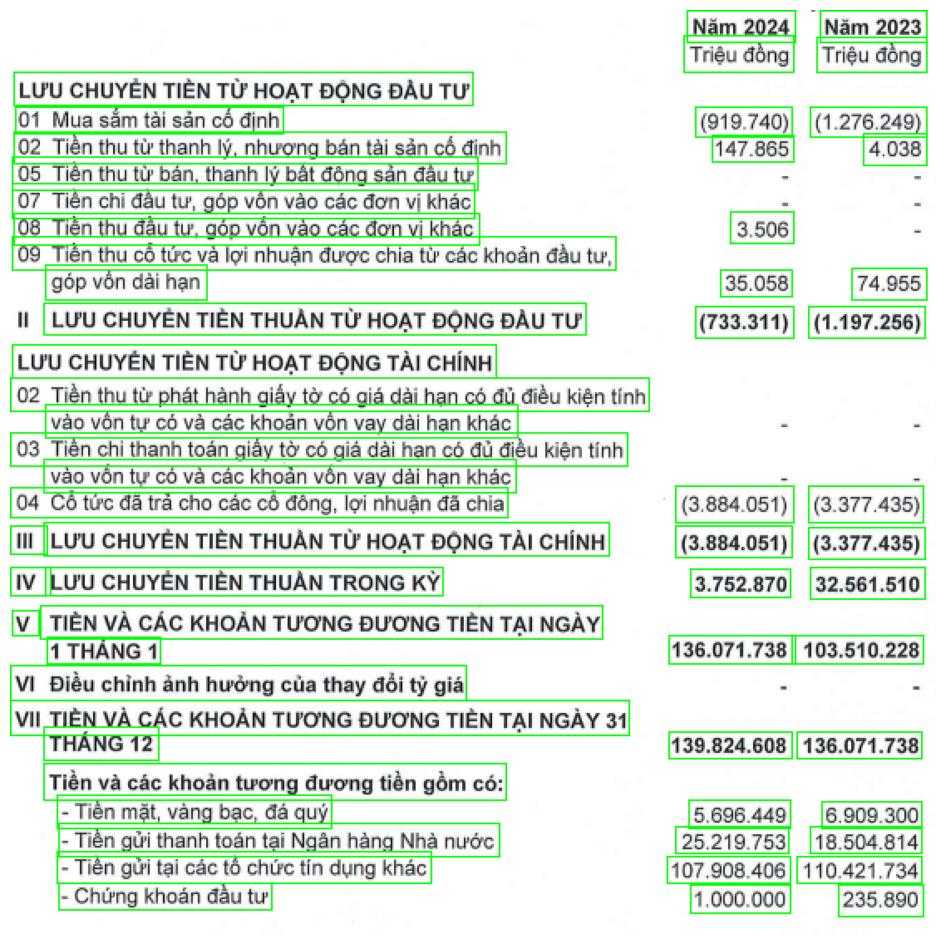

      0                                                  1            2  \
0                                                              Nam 2024   
1                                                            Trieu dong   
2                        LUUCHUYEN TIEN TUHOAT DONG DAU TU                
3                               01 Mua sam tai san co djnh    (919.740)   
4        02 Tien thu tr thanh ly,nhuong ban tai san co ...      147.865   
5         05 Tien thu tr ban, thanh ly bat dong san dau tu                
6          07 Tien chi dau tu, gop von vao cac don vj khac                
7           08 Tien thu dau tu,gop von vao cac don vj khac        3.506   
8        09 Tien thu co turc va loi nhuan duoc chia tr ...                
9                                          gop von dai han       35.058   
10                  LUUCHUYENTIEN THUAN TUHOAT DONG DAU TU    (733.311)   
11                     LUUCHUYEN TIEN TUHOAT DONG TAICHiNH                
12       02 Tien thu tr p

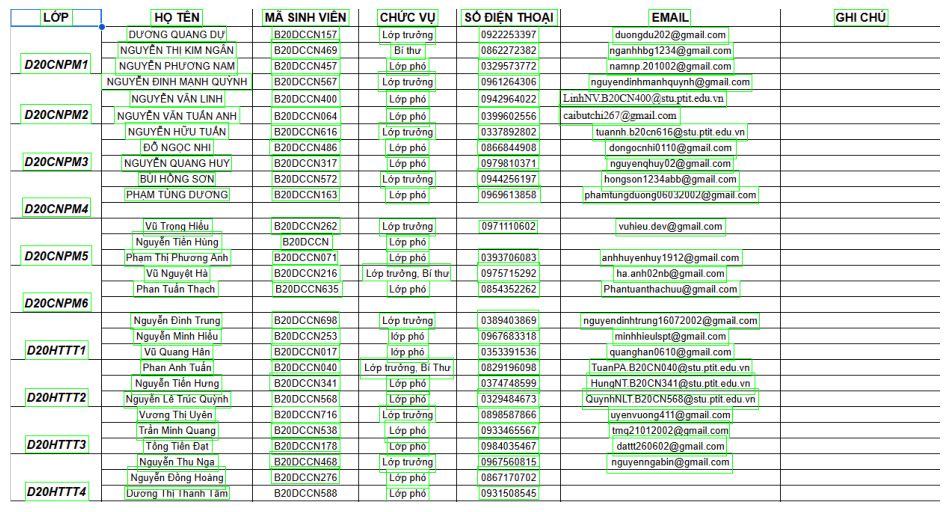

           0                       1             2                    3  \
0        LOP                  HO TEN  MA SINH VIEN              CHUC VU   
1                     DUONG QUANG DU    B20DCCN157           Lop truong   
2                NGUYEN TH! KIM NGAN    B20DCCN469              Bi thur   
3   D20CNPM1       NGUYEN PHUONG NAM    B20DCCN457              Lop pho   
4             NGUYEN DINH MANH QUYNH    B20DCCN567          Lop trurong   
5                    NGUYEN VAN LINH    B20DCCN400              Lop pho   
6   D20CNPM2     NGUYEN VAN TUAN ANH    B20DCCN064              Lop pho   
7                    NGUYEN HOU TUAN    B20DCCN616           Lop truong   
8                        DO NGOC NHI    B20DCCN486              Lop pho   
9   D20CNPM3        NGUYEN QUANG HUY    B20DCCN317              Lop pho   
10                      BUI HONG SON    B20DCCN572           Lop truong   
11                   PHAM TUNG DUONG    B20DCCN163              Lop pho   
12  D20CNPM4             

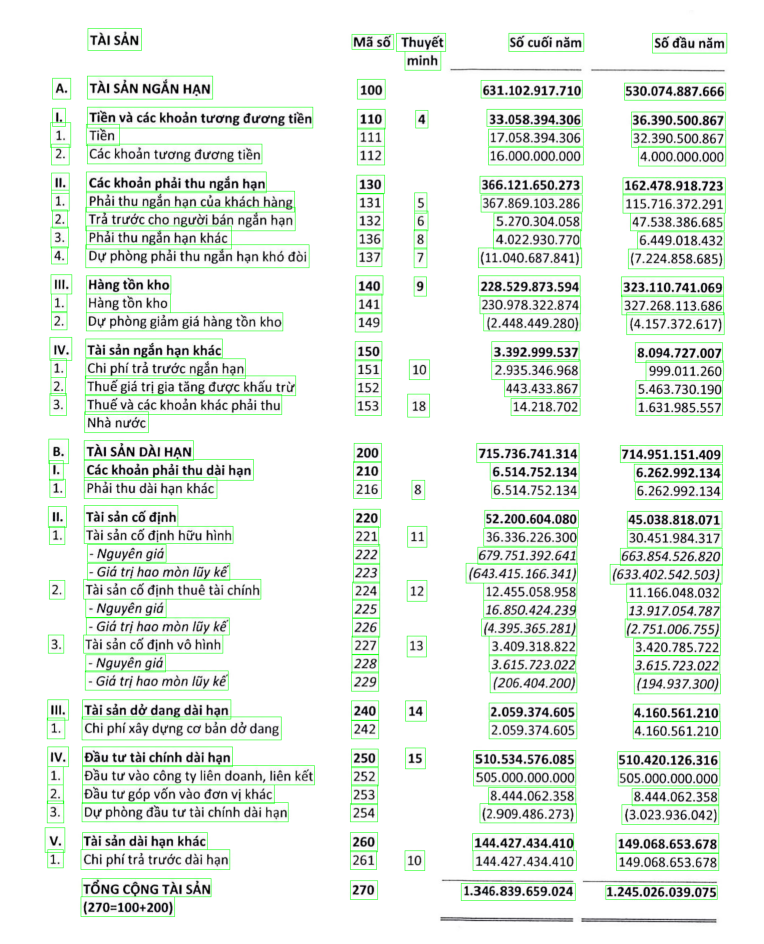

       0                                       1      2       3  \
0                                         TAISAN  Ma so  Thuyet   
1                                                          minh   
2     A.                        TAI SAN NGAN HAN    100           
3     I.      Tien va cac khoan tuong duong tien    110       4   
4     I.                                    Tien    111           
5     2.              Cac khoan tuong duong tien    112           
6    II.             Cac khoan phai thu ngan han    130           
7     I.        Phai thu ngan han cua khach hang    131       5   
8     2.        Tra truoc cho ngudi ban ngan han    132       6   
9     3.                  Phai thu ngan han khac    136       8   
10    4.      Dy phong phai thu ngan han kho doi    137       7   
11  III.                            Hang ton kho    140       9   
12    I.                            Hang ton kho    141           
13    2.          Du phong giam gia hang ton kho    149       

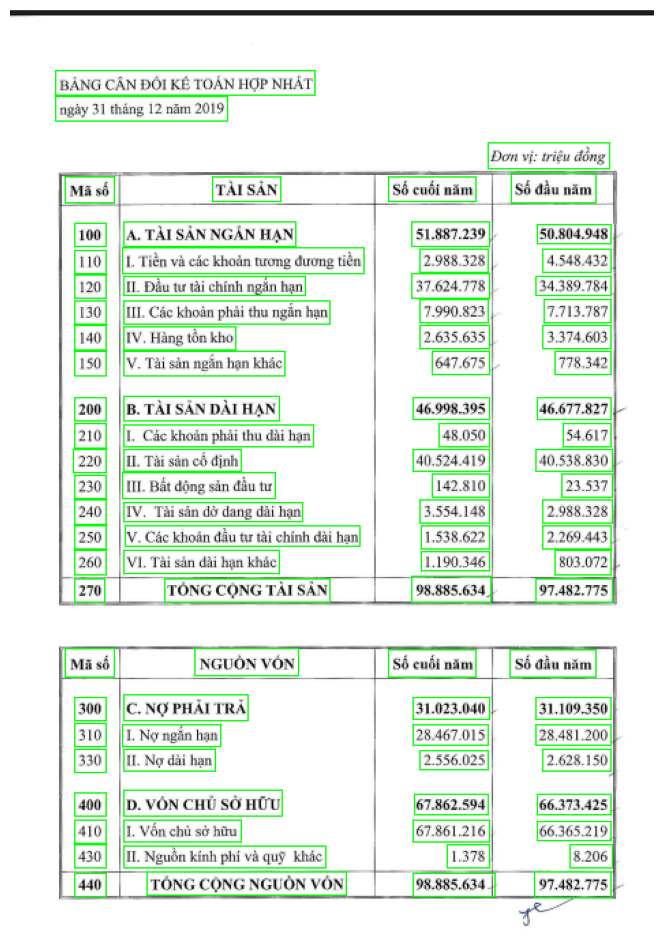

        0                                        1            2  \
0                    BANG CAN DOI KE TOAN HOP NHAT                
1                        ngay 31 thang 12 nam 2019                
2                                                                 
3   Ma so                                   TAISAN  So cuoi nam   
4     100                         A.TAISANNGAN HAN   51.887.239   
5     110  I. Tien va cac khoan turong durong tien    2.988.328   
6     120           II. Dau tur tai chinh ngan han   37.624.778   
7     130        III. Cac khoan phai thu ngan han.    7.990.823   
8     140                         IV. Hang ton kho    2.635.635   
9     150                 V. Tai san ngan han khac      647.675   
10    200                          B. TAISANDAIHAN   46.998.395   
11    210            I. Cac khoan phai thu dai han       48.050   
12    220                      II. Tai san co djnh   40.524.419   
13    230                III. Bat dong san dau tur      142.81

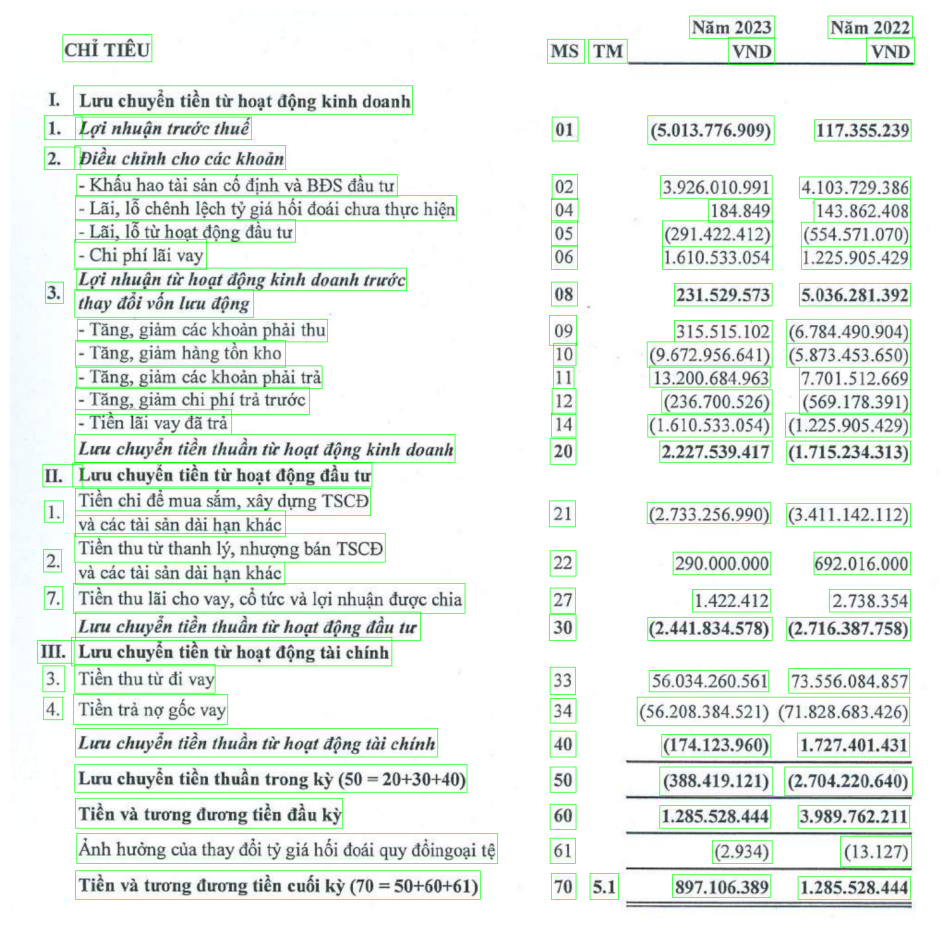

                                                    0   1    2  \
0                                                                
1                                            CHI TIEU  MS   TM   
2           Luru chuyen tien tir hoat dong kinh doanh            
3                             I. Lgi nhugn truoc thue  01        
4                         2. Dieu chinh cho cac khoan            
5            -Khau hao tai san co dinh va BDS dau tur  02        
6   -Lai, lo chenh lech ty gia hoi doai chua thuc ...  04        
7                       -Lai, lo tir hoat dong dau tu  05        
8                                    -Chi phi lai vay  06        
9            Loi nhuan tir hoat dong kinh doanh truoc            
10                                                 3.  08        
11                              thay doi von luu dong            
12                      -Tang,giam cac khoan phai thu  09        
13                            -Tang,giam hang ton kho  10        
14        

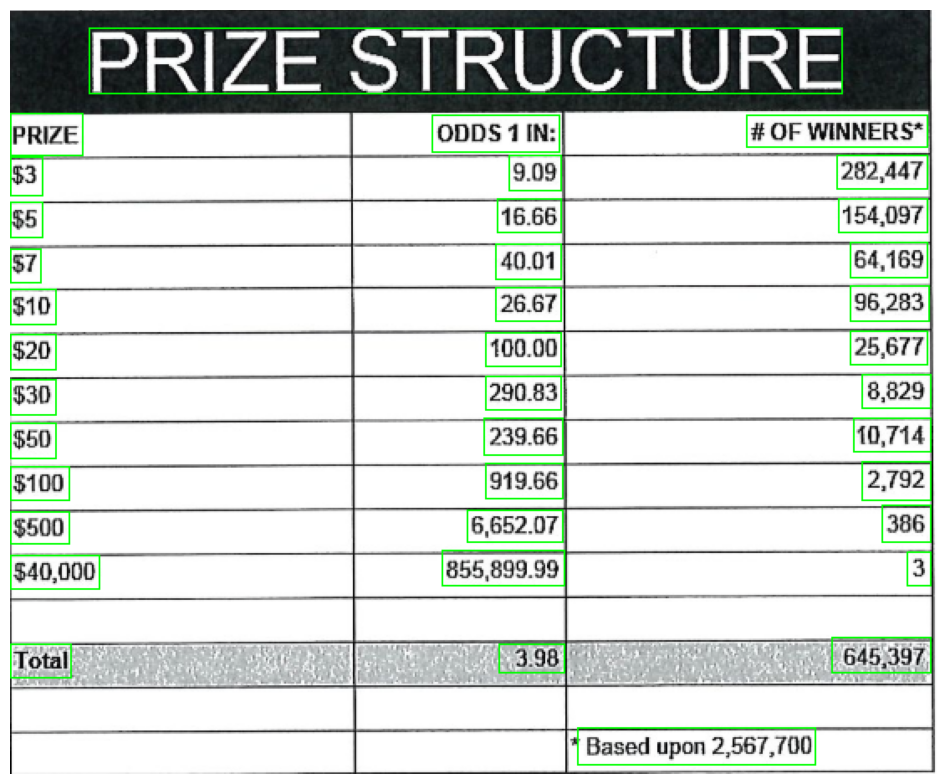

          0              1             2
0            PRZESTRUCTURE              
1     PRIZE        ODDS1IN  #OF WINNERS*
2        $3           9.09       282.447
3        $5          16.66       154.097
4        $7          40.01        64.169
5       $10          26.67        96.283
6       $20         100.00        25.677
7       $30         290.83         8.829
8       $50         239.66        10.714
9      $100         919.66         2.792
10     $500       6.652.07           386
11  $40,000     855.899.99             3
12    Total           3.98       645.397
13                                      
[2025/04/18 10:29:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


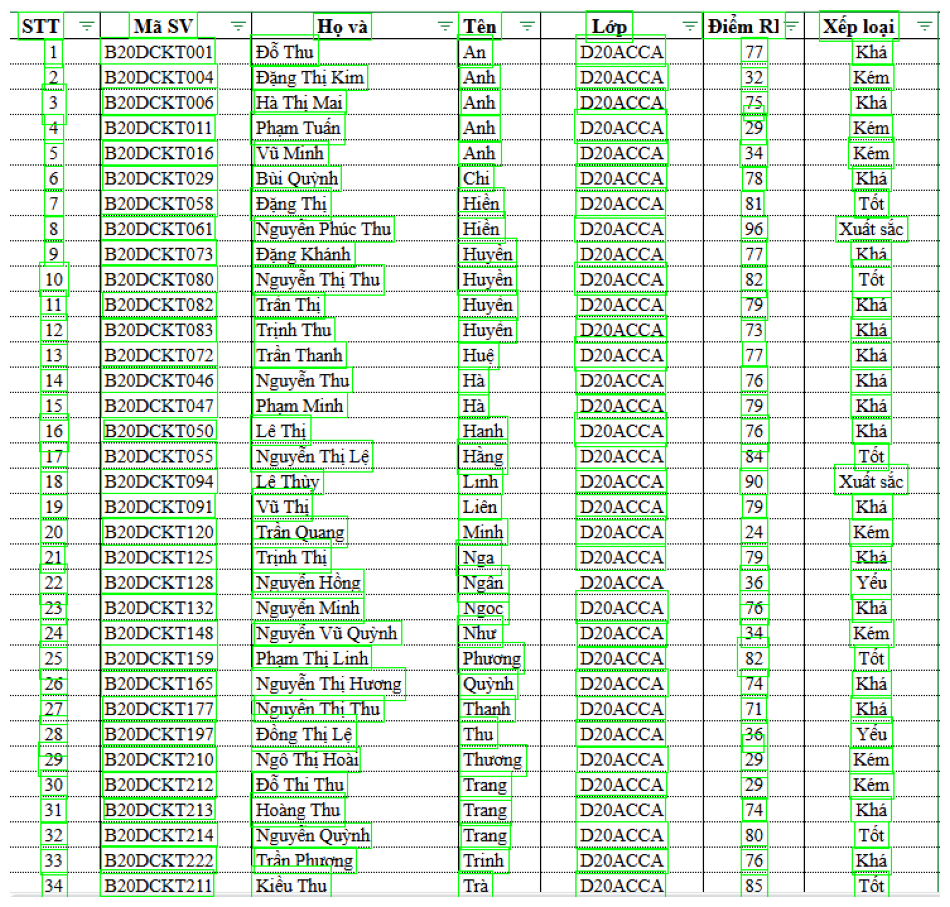

      0           1                 2       3        4          5 6         7
0   STT       Ma SV             Ho va     Ten      Lop    Diem R1    Xep loai
1     1  B20DCKT001            DO Thu      An  D20ACCA         77         Kha
2     2  B20DCKT004      Dang Thi Kim     Anh  D20ACCA         32         Kem
3    3.  B20DCKT006        Ha Thi Mai     Anh  D20ACCA  75 ......         Kha
4     4  B20DCKT011         Pham Tuan     Anh  D20ACCA         29         Kem
5     5  B20DCKT016           Vu Minh     Anh  D20ACCA         34         Kem
6     6  B20DCKT029         Bui Quynh     Chi  D20ACCA         78         Kha
7     7  B20DCKT058          Dang Thi    Hien  D20ACCA         81         Tot
8     8  B20DCKT061   Nguyen Phuc Thu    Hien  D20ACCA         96    Xuat sac
9     9  B20DCKT073        Dang Khanh   Huyen  D20ACCA         77         Kha
10   10  B20DCKT080    Nguyen Thi Thu   Huyen  D20ACCA         82         Tot
11   11  B20DCKT082          Tran Thi   Huyen  D20ACCA         7

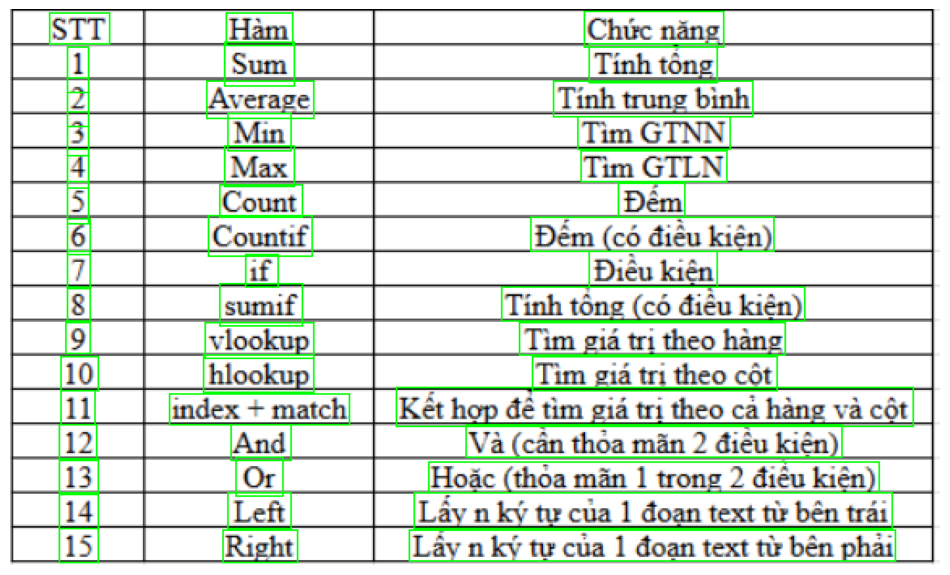

      0             1                                            2
0   STT           Ham                                    Chuc nang
1     1           Sum                                   Tinh tong.
2     2       Average                              Tinh trung binh
3     3           Min                                     Tim GTNN
4     4           Max                                     Tim GTLN
5     5         Count                                          Dem
6     6       Countif                           Dem (co dieu kien)
7     7            if                                    Dieu kien
8     8         sumif                    Tinh tong (co dieu kien).
9     9       vlookup                        Tim gia tri theo hang
10   10       hlookup                         Tim gia tri theo cot
11   11  index +match  Ket hop de tim gia tri theo ca hang va cot.
12   12           And               Va (can thoa man 2 dieu kien).
13   13            Or          Hoac (thoa man 1 trong 2 dieu k

In [11]:
for img in os.listdir('image_test'): 
    path = os.path.join('image_test', img)
    a = tool.process_single_image_paddle_all(img_path= path, draw= True)
    df = pd.DataFrame(a)
    # Save CSV file 
    os.makedirs('OUT_EXCEL', exist_ok= True)
    df.to_excel(f'OUT_EXCEL/out_{img[:-4]}.xlsx')       
    print(df)

# For testing some idea

In [ ]:
# path = r'test.png'
class Processing:
    def __init__(self):
        self.reader = easyocr.Reader(['vi'], verbose=False)
        
    def find_rects_texts(self, img_path, mode_draw = 1):
        paddle_reader = PaddleOCR(lang='en', show_log=False)

        image = cv2.imread(img_path)
        # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # lower_red = np.array([0, 18, 110])  # H: 169-175, S: 53-159, V: 134-255
        # upper_red = np.array([180, 255, 255])

        # # Lọc vùng đỏ trong ảnh
        # mask = cv2.inRange(hsv, lower_red, upper_red)

        # # Biến vùng đỏ thành trắng trong ảnh gốc
        # image[mask > 0] = [255, 255, 255]

        # # Làm mờ nhẹ để giảm nhiễu (Gaussian blur)
        # blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # # Tăng tương phản bằng histogram equalization
        # equalized = cv2.equalizeHist(blurred)

        # # Adaptive thresholding để phân vùng rõ chữ
        # thresh = cv2.adaptiveThreshold(
        #     equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #     cv2.THRESH_BINARY_INV, 21, 10
        # )

        # # Loại bỏ nhiễu nhỏ bằng morphological operations
        # kernel = np.ones((1, 1), np.uint8)
        # processed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # image = processed.copy()
        img = image.copy()

        w, h = image.shape[:2]
        image = cv2.resize(image, (int(h * 2.4), int(w * 1.2)))

        # Chạy OCR để detect box
        result = paddle_reader.ocr(image, cls = True)

        result = result[0]

        boxes = [line[0] for line in result]
        rects = []
        horizontal_list = []
        texts = []


        for box in boxes:
            box = np.array(box, dtype=np.float32)
            x, y, w, h = cv2.boundingRect(box)

            # Tọa độ đã scale
            x1 = int(x / 2.4)
            y1 = int(y / 1.2)
            x2 = int((x + w) / 2.4)
            y2 = int((y + h) / 1.2)

            rects.append([x1, y1, x2, y2])
            horizontal_list.append([x1, x2, y1, y2])

        rects = np.array(rects, dtype=int)


        results = self.reader.recognize(img, horizontal_list=horizontal_list, free_list=[])


        for box, text, confidence in results:
            chars = list(text)  # Tách text thành danh sách ký tự
            for i in range(1, len(chars)):
                if chars[i] == '1' and chars[i - 1] == 'I':
                    chars[i] = 'I'
            text = ''.join(chars)
            if text == '1.':
                text = 'I.'
            elif text == '11.':
                text = 'II.'
            texts.append(text)
        if mode_draw:
            for rect in rects:
                x1, y1, x2, y2 = rect
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            plt.figure(figsize=(12, 12))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
        # rect in rects is [x1, y1, x2, y2]
        return rects, texts
    def check_line(sefl, box1, box2):
        if abs((box1[1] + box1[3]) // 2 - (box2[1] + box2[3]) // 2) < 10:
            return True
        return False

    def rects_texts_ncollum_processed(self, rects, texts):
        rects_new = []
        txts_new = []

        current_rect = []
        current_txt = []

        max_collum= 0

        for i in range(len(texts)):
            texts[i] = texts[i].strip()
            if(texts[i] == ''):
                continue

            if texts[i][0].isdigit() and texts[i][-1].isdigit():
                texts[i] = texts[i].replace(',', '.')

            if len(current_rect) == 0:
                current_rect.append(rects[i])
                current_txt.append(texts[i])
            else:
                if self.check_line(current_rect[-1], rects[i]):
                    current_rect.append(rects[i])
                    current_txt.append(texts[i])
                    
                    # print(current_txt)
                else:
                    for x in range(len(current_rect)):
                        for y in range(x + 1, len(current_rect)):
                            x_cen_x = (current_rect[x][0] + current_rect[x][2]) // 2
                            x_cen_y = (current_rect[y][0] + current_rect[y][2]) // 2
                            
                            if x_cen_x > x_cen_y:
                                current_rect[x], current_rect[y] = current_rect[y], current_rect[x]
                                current_txt[x], current_txt[y] = current_txt[y], current_txt[x] 
                    current_rect = np.array(current_rect)
                    rects_new.append(current_rect)
                    txts_new.append(current_txt)
                    
                    max_collum = max(max_collum, len(current_txt))
                    
                    
                    current_rect = [rects[i]]
                    current_txt = [texts[i]]
                    
        if len(current_rect) > 0:
            for x in range(len(current_rect)):
                for y in range(x + 1, len(current_rect)):
                    x_cen_x = (current_rect[x][0] + current_rect[x][2]) // 2
                    x_cen_y = (current_rect[y][0] + current_rect[y][2]) // 2
                    
                    if x_cen_x > x_cen_y:
                        current_rect[x], current_rect[y] = current_rect[y], current_rect[x]
                        current_txt[x], current_txt[y] = current_txt[y], current_txt[x]

            current_rect = np.array(current_rect)
        
            rects_new.append(current_rect)
            txts_new.append(current_txt)
            
            max_collum = max(max_collum, len(current_txt))

            # rects_new = np.array(rects_new)
        return rects_new, txts_new, max_collum

    def find_text_each_row(self, box_cols, list_rects, list_texts):
        array_text_reconstructed = []
        n_cols = len(box_cols)
        
        # each row
        for id_rects in range(len(list_rects)):
            array_text_cur = [' '] * n_cols
            
            # each box in row
            for id_rect in range(len(list_rects[id_rects])):
                x1, y1, x2, y2 = list_rects[id_rects][id_rect]
                x_cen = (x1 + x2) // 2

                for id_cols in range(n_cols):
                    x_min_box_col, x_max_box_col = box_cols[id_cols]
        
                    if x_cen >= x_min_box_col and x_cen <= x_max_box_col:
                        if array_text_cur[id_cols] == ' ':
                            array_text_cur[id_cols] = list_texts[id_rects][id_rect]
                        else:
                            array_text_cur[id_cols] += ' ' + list_texts[id_rects][id_rect]
                
            array_text_reconstructed.append(array_text_cur)

        return array_text_reconstructed
    def find_box_cols(self, rects_box, n_cols):
        col_box_xmin_xmax = []
        for row in rects_box:
            if len(row) == n_cols:
                col_box_xmin_xmax.append(row[:, [True, False, True, False]].flatten())
        col_box_xmin_xmax = np.array(col_box_xmin_xmax)

        row_arg_min = np.argmin(col_box_xmin_xmax, axis= 0)
        row_arg_max = np.argmax(col_box_xmin_xmax, axis= 0)

        cols_index = np.arange(col_box_xmin_xmax.shape[1])
        
        # print(col_box_xmin_xmax)
        
        x_min_each_cols = np.expand_dims(col_box_xmin_xmax[row_arg_min, cols_index][::2], axis= 0).T
        x_max_each_cols = np.expand_dims(col_box_xmin_xmax[row_arg_max, cols_index][1:][::2], axis= 0).T

        return np.concatenate([x_min_each_cols, x_max_each_cols], axis= 1)

    def processing(self, img_path, mode_draw = 0):
        rects, texts = self.find_rects_texts(img_path= img_path, mode_draw= mode_draw)
        rects_restructed, texts_restructed, n_cols = self.rects_texts_ncollum_processed(rects= rects, texts= texts)
        box_xmin_xmax_each_col = self.find_box_cols(rects_box= rects_restructed, n_cols= n_cols)
        array_texts_restructed = self.find_text_each_row(box_cols= box_xmin_xmax_each_col, list_rects= rects_restructed, list_texts= texts_restructed)
        return array_texts_restructed

In [2]:
from paddleocr import PaddleOCR
model = PaddleOCR(lang='en', show_log=False,use_gpu = False)
res = model.ocr(img= r'G:\Table Extraction from Images to CSV Excel\image_test\10.png', rec= False)


[2025/04/17 15:40:55] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


In [ ]:
res[0]

[[505.0, 638.0], [559.0, 638.0], [559.0, 658.0], [505.0, 658.0]]

In [10]:
tool = Processing()

In [16]:
path = r'G:\vietnamese-ocr\test\9.png'

[2025/04/15 03:21:08] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process


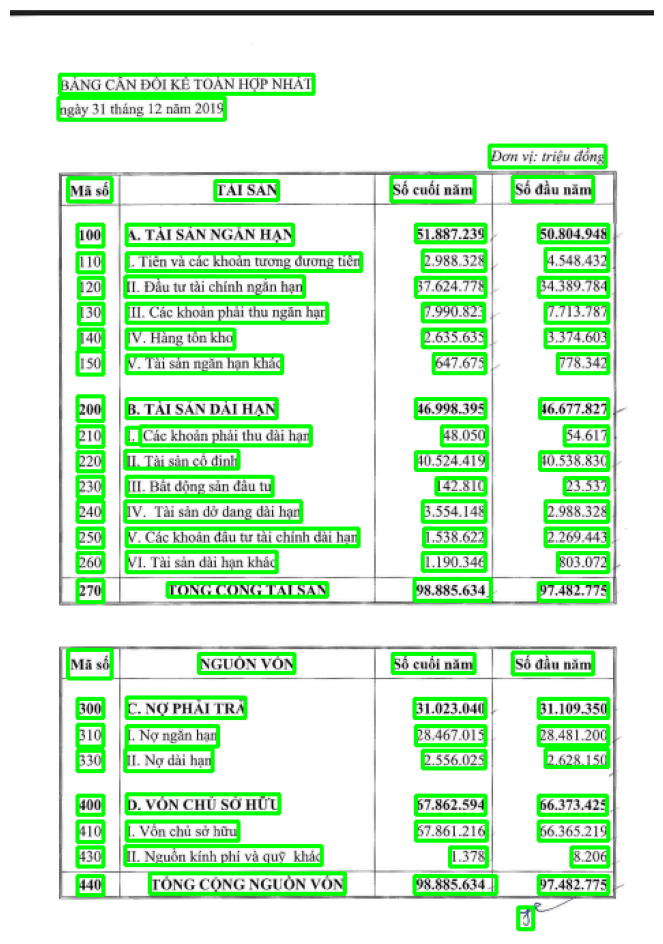

In [17]:
a = tool.processing(img_path= path, mode_draw= 1)

In [18]:
pd.DataFrame(a)

0  1                                     2             3           4
0                      BANG CÂN ĐÔIKÉTOÁN HỢP NH4I                          
1                        ngày 31 tháng 12 nam 2015                          
2                                                                           
3   Mã sí                                  TAI SAN                          
4     100                      A. TAI SÀN NGAN HẠN    51.887.239  50.804.948
5     110     [ Tién và các khodn lưong duong tien     2.988 328   4.548.432
6     120             IL Dau 1ư tài chính ngan han    37.624.776  34.389.784
7     [30         [IL, Cac khoun phaỉ thu ngun hụn     7.990.82-   7.713.787
8     140                         [V. Hàng ton khu     2.635.635   3.374.603
9     150                  V.Tai san ngán han khac       647.675     778.342
10    200                        B. TÀI SẢN DÀlHẠN    46.998.395  46.677.827
11    210  1           Cac khoun phuai thu dai han        48.050      54.617
12    220                      IL. Tai San cỦ dinh    40.524.419  10.538 830
13    230                  IIL Bẳt dong san dau lu       142.810      23.537
14    240              IV. Tai sân dở dang dai han     3.554.148   2.988.528
15    250     V Cac khoan diu tu tai chinh dai hạr     1.538.622    2.269443
16    260                 VI. Tài san dai hun khúc     1.190.346     803.072
17    270                           ToyCCovGTAisa(    98.885.634  97.482.775
18  Mã sỗ                                NGUỎN VON                          
19    300                             C.NỢ PHẴl TR    31.023.(M6  31.109.350
20    310                            1 No ngan han    28.467 0[5  28.481.200
21    330                           IL, Nợ dàỉ hạn     2.556.025    2628.150
22    400                       D. VMN CHÚ SỞ IIỮU    67.862.594  66.373.425
23    410                         1 von chu sử hữu    67.861.216  66.365.219
24    430            IL Nzuon kinh phi và qus khác         1.378      8..206
25    440                     TONG CQNG; NGUÒN VON  98.885.634 |  97.482.775
26

In [ ]:
import numpy as np
a = np.array([[1, 2, 3],
              [2, 3, 4]])
a = a * np.array([10, 20, 30])
a

array([[ 10,  40,  90],
       [ 20,  60, 120]])